In [66]:
import pykep as pk
import numpy as np
import json

from matplotlib import pyplot as plt
%matplotlib inline

# We import the dataset containing the info on the tracked population
The files needed are:
* satcat.txt (from https://celestrak.com/satcat/search.php) - This contains, for some, the RCS in meters.
* satcat_json (from https://www.space-track.org/basicspacedata/query/class/gp/decay_date/null-val/epoch/%3Enow-30/orderby/norad_cat_id/format/json) -This has all information, but the RCS that only carries three levels small, medium big.


In [50]:
# Import the SATCAT
satcat = pk.util.read_satcat("data/satcat.txt")
# Import the json catalogue
with open("data/satcat.json", "r") as file:
    satcat_json = json.load(file)
print("Satellites number in json: ", len(satcat_json))
print("Satellites number in txt: ", len(satcat))

Satellites number in json:  23966
Satellites number in txt:  51407


The txt (SATCAT) contains more entries as all past decayed objects are also present, while in the json we only hve the currently orbiting ones

In [51]:
# Lets build the various orbiting objects from the TLEs
debris = []
for entry in satcat_json:
    try:
        line1 = entry["TLE_LINE1"]
        line2 = entry["TLE_LINE2"]
        debris.append(pk.planet.tle(line1, line2))
    except RuntimeError:
        # The alpha-5 format (https://www.space-track.org/documentation#tle-alpha5) is accounted for (ignored)
        # here. 
        line1 = list(line1)
        line1[2] = '0'
        line1 = ''.join(line1)
        line2 = list(line2)
        line2[2] = '0'
        line2 = ''.join(line2)
        debris.append(pk.planet.tle(line1, line2))

print("Satellites number with valid TLEs:", len(debris))

Satellites number with valid TLEs: 23966


In [52]:
# For each debris we retrieve and monkey patch the planet class with its collision radius
for deb, deb_data in zip(debris, satcat_json):
    key = deb.name.strip()
    if key in satcat and satcat[key].radarA.strip() != "N/A":
        radius = np.sqrt(float(satcat[key].radarA)/np.pi)
    else:
        if deb_data["RCS_SIZE"] == "SMALL":
            radius = 0.15
        elif deb_data["RCS_SIZE"] == "MEDIUM":
            radius = 0.55
        else:
            radius = 2.
    deb.collision_radius = radius

In [65]:
# We create the initial state for all satellites that are not decayed and filtered
r = []
v = []
al = []
el = []
incl = []
radius= []
to_satcat_index = []
n_decayed = 0
for j, deb in enumerate(debris):
    try:
        rr, vv = deb.eph(pk.epoch_from_iso_string("20220128T235954"))
        a,e,i,Om,om,nu = pk.ic2par(rr, vv, mu=pk.MU_EARTH)
        if a < 1e7:
            r.append(rr)
            v.append(vv)
            radius.append(deb.collision_radius)
            al.append(a)
            el.append(e)
            incl.append(i*pk.RAD2DEG)
            to_satcat_index.append(j)
    except:
        n_decayed+=1
radius = np.array(radius)
print("Number of satellites decayed: ", n_decayed)
print("Number of satellites in the simulation: ", len(indexes))

Number of satellites decayed:  5
Number of satellites in the simulation:  19772


# We now produce some plots on the satellites to be simulated


In [20]:
%matplotlib inline

In [21]:
from matplotlib.pylab import plt

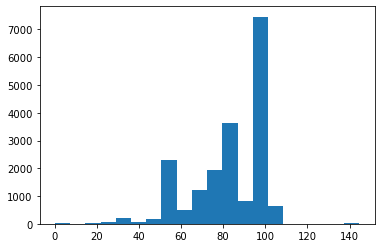

In [22]:
fig = plt.figure()

plt.hist(incl, bins = 20);

In [23]:
import cascade as csc
import numpy as np
import pykep as pk
from copy import deepcopy
from tqdm.notebook import tqdm
import heyoka as hy

In [24]:
# Dynamical variables.
x,y,z,vx,vy,vz = hy.make_vars("x","y","z","vx","vy","vz")

# Constants.
GMe = pk.MU_EARTH
C20 = -4.84165371736e-4
Re = pk.EARTH_RADIUS

# Create Keplerian dynamics.
dyn = csc.dynamics.kepler(mu = GMe)

# Add the J2 terms.
magR2 = hy.sum_sq([x, y, z])
J2term1 = GMe*(Re**2)*np.sqrt(5)*C20/(2*magR2**(1./2))
J2term2 = 3/(magR2**2)
J2term3 = 15*(z**2)/(magR2**3)
fJ2X = J2term1*x*(J2term2 - J2term3)
fJ2Y = J2term1*y*(J2term2 - J2term3)
fJ2Z = J2term1*z*(3*J2term2 - J2term3)
dyn[3] = (dyn[3][0], dyn[3][1] + fJ2X)
dyn[4] = (dyn[4][0], dyn[4][1] + fJ2Y)
dyn[5] = (dyn[5][0], dyn[5][1] + fJ2Z)

In [25]:
rarr = np.array(r)
varr = np.array(v)

In [26]:
sim = csc.sim(rarr[:,0],rarr[:,1],rarr[:,2],varr[:,0],varr[:,1],varr[:,2],radius,0.23 * 806.81,dyn=dyn)

[2022-01-31 15:02:44.925] [cascade] [info] cascade logger initialised


In [29]:
final_t = 86400*365

In [30]:
pbar = tqdm(total=final_t)

while sim.time < final_t:
    orig_time = sim.time
    
    oc = sim.step()
    
    pbar.update(sim.time - orig_time)
   
    if oc == csc.outcome.collision:
        # TODO different code needed for crash
        # on Earth here.
        pi, pj = sim.interrupt_info
        
        print("Collision detected, re-initing particles {} and {}".format(pi, pj))
        
        new_x = deepcopy(sim.x)
        new_y = deepcopy(sim.y)
        new_z = deepcopy(sim.z)
        
        new_vx = deepcopy(sim.vx)
        new_vy = deepcopy(sim.vy)
        new_vz = deepcopy(sim.vz)
        
        new_sizes = deepcopy(sim.sizes)

        for idx in [pi, pj]:
            a = rng.uniform(1.02*Re, 1.3*Re)
            e = rng.uniform(0, 0.02)
            inc = rng.uniform(0, 0.05)
            om = rng.uniform(0, 2*np.pi)
            Om = rng.uniform(0, 2*np.pi)
            nu = rng.uniform(0, 2*np.pi)
            size = rng.uniform(0.01, 0.1)

            r, v = pk.par2ic([a, e, inc, om, Om, nu], GMe)

            new_x[idx] = r[0]
            new_y[idx] = r[1]
            new_z[idx] = r[2]

            new_vx[idx] = v[0]
            new_vy[idx] = v[1]
            new_vz[idx] = v[2]
            
            new_sizes[idx] = size

        sim.set_new_state(new_x, new_y, new_z, new_vx, new_vy, new_vz, new_sizes)
    elif oc == csc.outcome.reentry:
        pi = sim.interrupt_info
        
        print("Particle {} re-entered".format(pi))
        break

pbar.close()
del pbar

  0%|          | 0/31536000 [00:00<?, ?it/s]

Collision detected, re-initing particles 13936 and 15415


NameError: name 'rng' is not defined

In [32]:
debris[13936]

Planet Name: 1987-060R  
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 398600800000000
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Ephemerides type: SGP4 propagator
TLE epoch: 2022-Jan-27 21:30:17.559645
TLE 1: 1 39654U 87060R   22027.89603657  .00000042  00000-0  53132-4 0  9999
TLE 2: 2 39654  65.0062 186.4374 0020453 261.7164  98.1602 14.31651468407121

In [33]:
debris[15415]

Planet Name: 2015-020J  
Own gravity parameter: 0.10000000000000001
Central body gravity parameter: 398600800000000
Planet radius: 0.10000000000000001
Planet safe radius: 0.10000000000000001
Ephemerides type: SGP4 propagator
TLE epoch: 2022-Jan-27 18:25:27.136436
TLE 1: 1 41721U 15020J   22027.76767519  .00000043  00000-0  14318-3 0  9991
TLE 2: 2 41721  82.4896 214.0273 0244945 245.3786 112.1619 12.74606552308163

In [35]:
radius[13936]

2.0

In [41]:
radius[15415]

2.0

In [48]:
(sim.x[13936] - sim.x[15415])**2 + (sim.y[13936] - sim.y[15415])**2 + (sim.z[13936] - sim.z[15415])**2 - 4*2**2

4.1302156716938043e-07

In [49]:
sim.sizes[13936]

2.0

In [18]:
a = "sde"

In [20]:
a[0] = 'e'

TypeError: 'str' object does not support item assignment